# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from time import time
import timeit

## Подготовка данных

### Загрузка данных

In [3]:
df = pd.read_csv("/datasets/autos.csv")

### Изучение данных

In [4]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Комментарий**: Данные соответствуют условию.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Комментарий**: Данных очень много - `354369` строк, также имеются пропуски в некоторых столбцах, типы данных соответствуют данным.

### Предобработка данных

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Комментарий**:
```
-VehicleType - 37490 пропусков(10.5%)
-Gearbox - 19833 пропуска(5.6%)
-Model - 19705 пропусков(5.6%)
-FuelType - 32895 пропуска(9.3%)
-Repaired - 71154 пропуска(20.1%)

```
Пропусков слишком много чтобы их просто удалять, поэтому пока что заполним их самыми популярными значениями

In [7]:
df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode()[0])
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode()[0])
df['Model'] = df['Model'].fillna(df['Model'].mode()[0])
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode()[0])
df['Repaired'] = df['Repaired'].fillna(df['Repaired'].mode()[0])

**Комментарий**: Пропуски заполнены самым популярным значением в столбце.

In [8]:
df = df.drop(['DateCrawled'], axis=1)
df = df.drop(['PostalCode'], axis=1)

**Комментарийй**: Удалены неинформативные признаки для задачи

### Исследовательский анализ

In [9]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

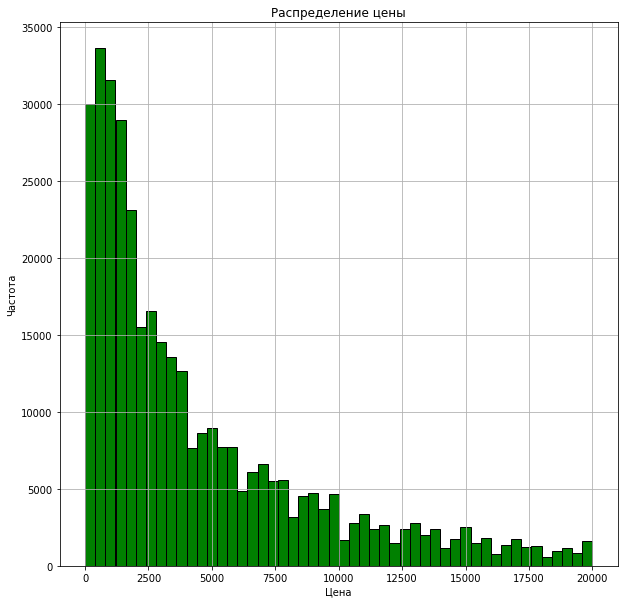

In [10]:
plt.figure(figsize=(10,10))
plt.hist(df['Price'], bins=50, color='green', edgecolor='black')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Большинство автомобилей стоят до `2500`, однако есть и машины цена которых находится в диапозоне `15000-20000`

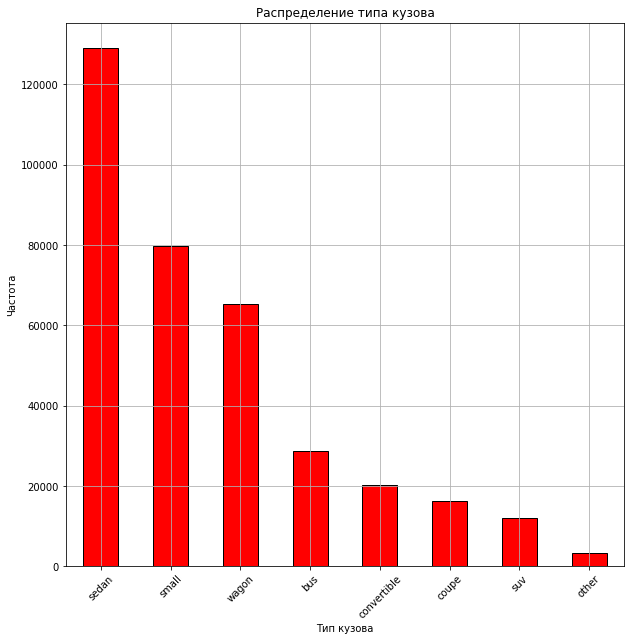

In [11]:
df['VehicleType'].value_counts().plot(kind='bar', color='red', edgecolor='black', figsize=(10,10))
plt.title('Распределение типа кузова')
plt.xlabel('Тип кузова')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Самым популярным кузовом является `sedan`, `small` идет на втором месте. Самыми не популярными являются `coupe`, `suv` и `other`

In [12]:
df['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [13]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

**Комментарий**: Явно присутствуют выбросы, в столбце есть годы регистрации, которые невозможны

In [14]:
df = df[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] >= 1950)]

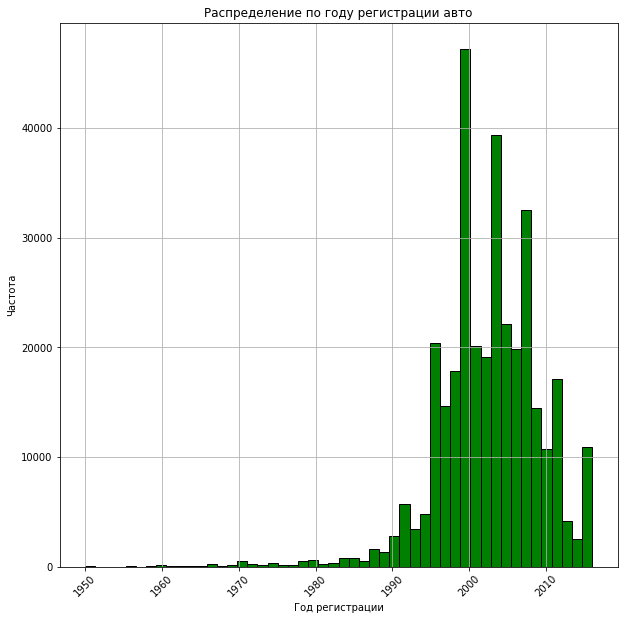

In [15]:
plt.figure(figsize=(10,10))
plt.hist(df['RegistrationYear'], bins=50, color='green', edgecolor='black')
plt.title('Распределение по году регистрации авто')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Комментарий**: Большинство авто были зарегистрированы примерно в `2000` года, также часто встречаются авто с регистрацией в `1950` года и в `1990`

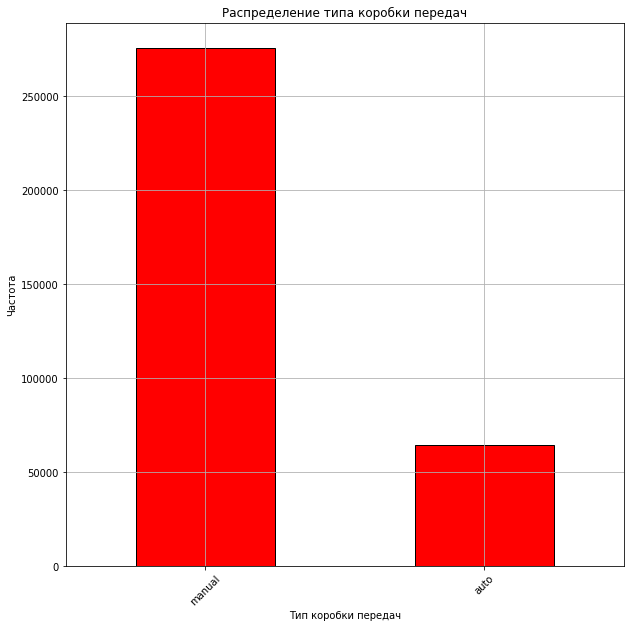

In [16]:
df['Gearbox'].value_counts().plot(kind='bar', color='red', edgecolor='black', figsize=(10,10))
plt.title('Распределение типа коробки передач')
plt.xlabel('Тип коробки передач')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Большинство авто идут с `manual` типом коробки передач, разница с `auto` почти в `7` раз

In [17]:
df['Power'].describe()

count    339593.000000
mean        111.045696
std         186.899948
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [18]:
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   286,   232,   150,
         156,    80,    82,    90,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,   132,   234,   158,    39,    92,    51,   135,    59,
          53,   209,

**Комментарий**: Снова есть явные выбросы, с невозможными значениями мощности

In [19]:
df = df[(df['Power'] <= 450) & (df['Power'] >= 50)]

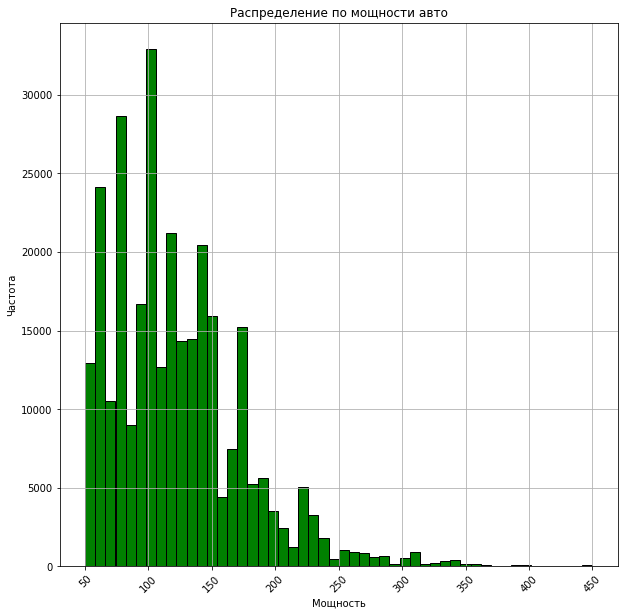

In [20]:
plt.figure(figsize=(10,10))
plt.hist(df['Power'], bins=50, color='green', edgecolor='black')
plt.title('Распределение по мощности авто')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Комментарий**: Большинство машин имеют мощность то `50` до `160`, есть и мощные авто вплоть до `400`

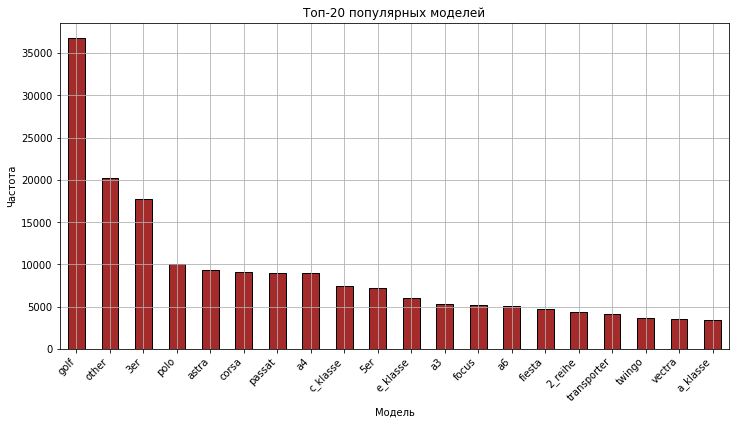

In [21]:
plt.figure(figsize=(12,6))
df['Model'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Топ-20 популярных моделей')
plt.xlabel('Модель')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


**Комментарий**: График распределения `20` самых популярных моделей

In [22]:
df['Kilometer'].describe()

count    297083.000000
mean     128589.064336
std       36609.740372
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [23]:
df['Kilometer'].value_counts()

150000    198334
125000     31556
100000     12703
90000      10210
80000       8947
70000       7715
60000       6718
50000       5569
40000       4439
30000       3840
20000       3203
5000        2965
10000        884
Name: Kilometer, dtype: int64

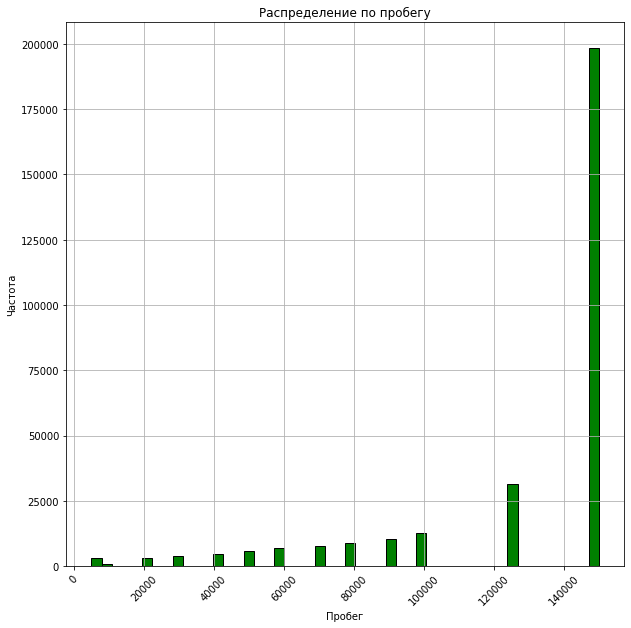

In [24]:
plt.figure(figsize=(10,10))
plt.hist(df['Kilometer'], bins=50, color='green', edgecolor='black')
plt.title('Распределение по пробегу')
plt.xlabel('Пробег')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Комментарий**: Почти `6000` авто с пробегом `150.000` скорее всего это просто максимально значение, которое можно указать

In [25]:
df['RegistrationMonth'].value_counts()

3     30371
6     27604
4     25715
5     25635
7     23818
10    22947
12    21236
11    21055
9     20956
1     20131
8     19789
0     18985
2     18841
Name: RegistrationMonth, dtype: int64

**Комментарий**: Для почти `500` авто указан месяц регистрации `0`, это `6.7%` от всех данных.

In [26]:
df = df[df['RegistrationMonth'] != 0]


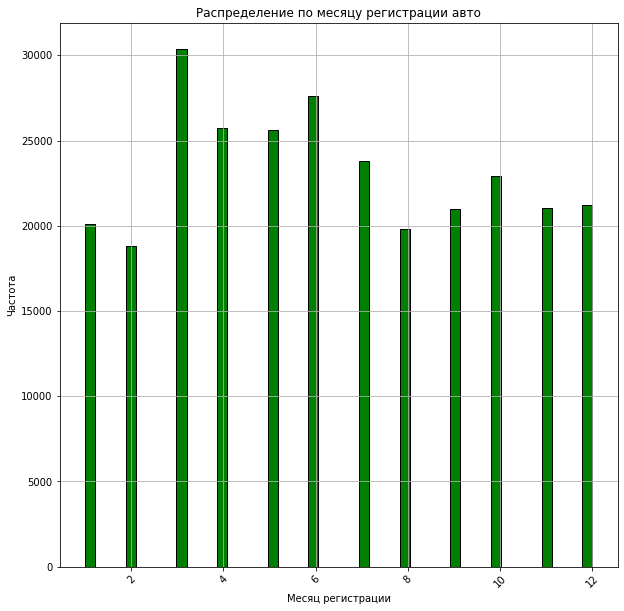

In [27]:
plt.figure(figsize=(10,10))
plt.hist(df['RegistrationMonth'], bins=50, color='green', edgecolor='black')
plt.title('Распределение по месяцу регистрации авто')
plt.xlabel('Месяц регистрации')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Комментарий**: Месяцы регистрации авто распределены равномерно 

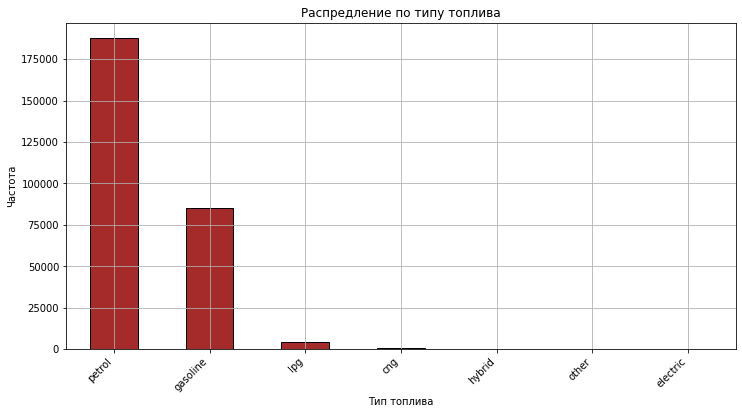

In [28]:
plt.figure(figsize=(12,6))
df['FuelType'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Распредление по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


**Комментарий**: Самым популярным типом топлива является `petrol`, а самые не популярные `cng`, `hybrid` и `other`

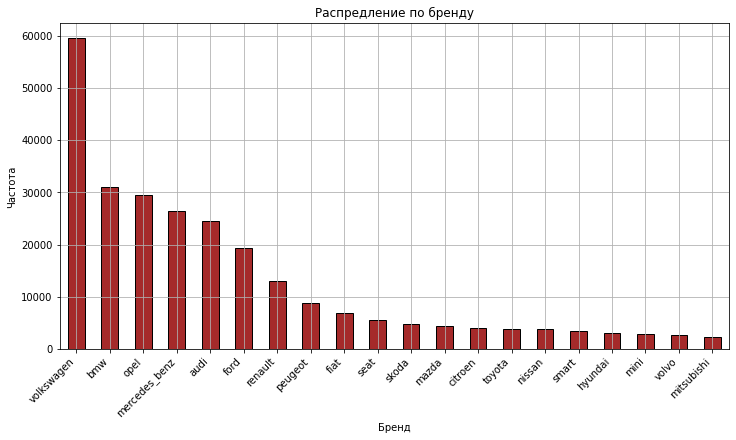

In [29]:
plt.figure(figsize=(12,6))
df['Brand'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Распредление по бренду')
plt.xlabel('Бренд')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


**Комментарий**: Самой популярной маркой является `Volkswagen`, затем идут `Opel` и `bmw`, а самые не популярные марки - `volvo`, `mitsubishi` и `alfa_romeo`

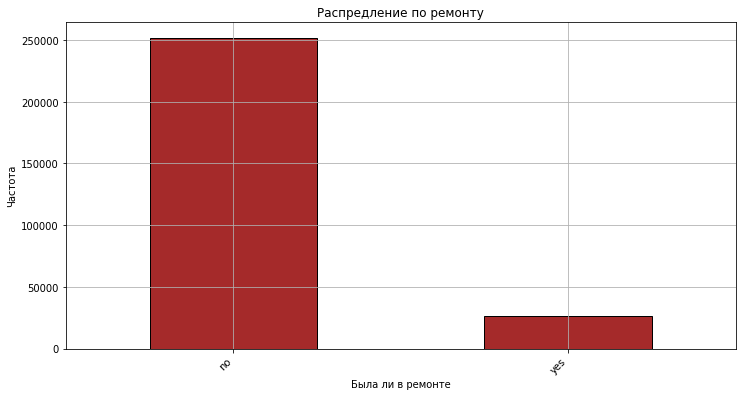

In [30]:
plt.figure(figsize=(12,6))
df['Repaired'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Распредление по ремонту')
plt.xlabel('Была ли в ремонте')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


**Комментарий**: Подавляющее количество авто не было в ремонте, ращница между `no` и `yes` почти в `10` раз в пользу `no`

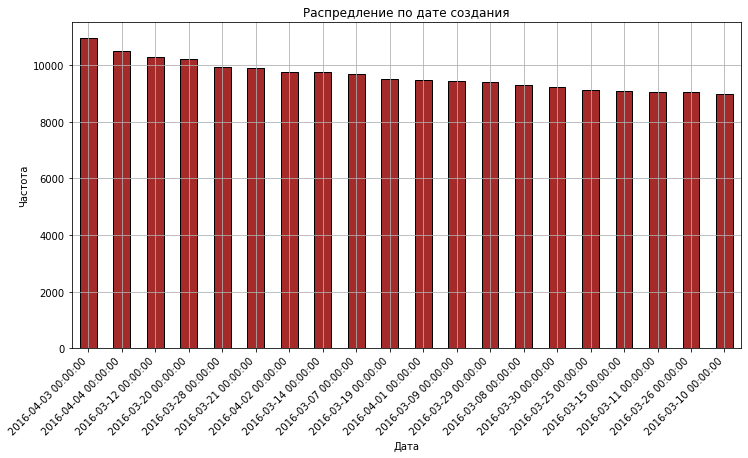

In [31]:
plt.figure(figsize=(12,6))
df['DateCreated'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Распредление по дате создания')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


**Комментарий**: Наши объявления были созданы примерно в одно время, эттой информацией можно пренебречь

In [32]:
df = df.drop(['DateCreated'], axis=1)

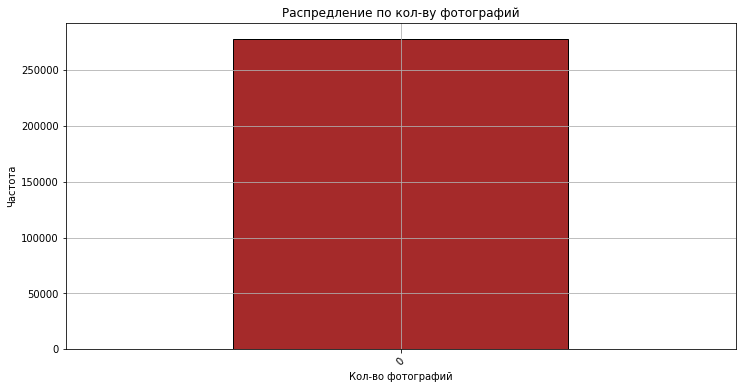

In [33]:
plt.figure(figsize=(12,6))
df['NumberOfPictures'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Распредление по кол-ву фотографий')
plt.xlabel('Кол-во фотографий')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Комментарий**: Везде `0` фотографий, можно удалить этот признак

In [34]:
df = df.drop(['NumberOfPictures'], axis=1)

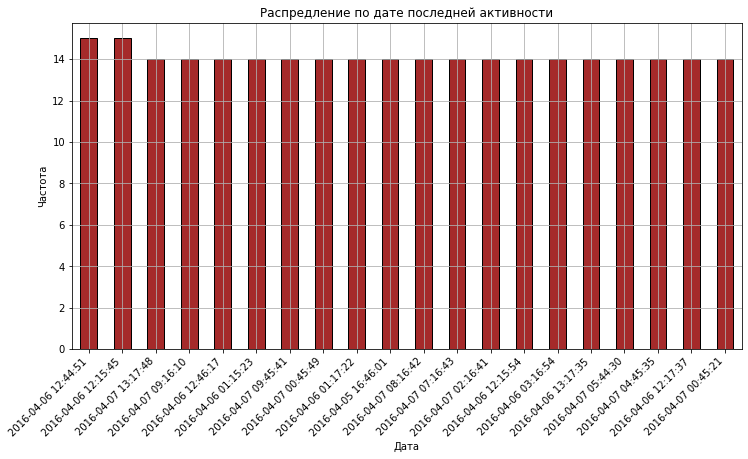

In [35]:
plt.figure(figsize=(12,6))
df['LastSeen'].value_counts().head(20).plot(kind='bar', color='brown', edgecolor='black')
plt.title('Распредление по дате последней активности')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


**Комментарий**: Вновь неинформативные данные, удаляем

In [36]:
df = df.drop(['LastSeen'], axis=1)

### Подготовка к обучению

In [37]:
RANDOM_STATE = 44

X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=RANDOM_STATE, test_size=0.25
)

num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

## Обучение моделей

In [38]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [5, 10],
        'model__min_samples_split': [2, 10]
    },
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=1)],
        'model__n_estimators': [700, 1500],
        'model__learning_rate': [0.05, 0.1],
    }
]

## Анализ моделей

In [39]:
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    refit=False,                 
    return_train_score=False
)

grid.fit(X_train, y_train)


cv_df = pd.DataFrame(grid.cv_results_)[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score']]
display(cv_df)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=10; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=10; total time=   1.2s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__mi

,params,mean_fit_time,mean_score_time,mean_test_score
0,{'model': DecisionTreeRegressor(random_state=4...,1.102617,0.095047,-2501.368214
1,{'model': DecisionTreeRegressor(random_state=4...,1.088281,0.093790,-2501.368214
2,{'model': DecisionTreeRegressor(random_state=4...,3.729018,0.098301,-2063.558895
3,{'model': DecisionTreeRegressor(random_state=4...,3.625948,0.093187,-2058.136590
4,"{'model': LGBMRegressor(n_jobs=1, random_state...",7.493420,2.302395,-1689.373360
5,"{'model': LGBMRegressor(n_jobs=1, random_state...",12.956607,6.140873,-1657.668214
6,"{'model': LGBMRegressor(n_jobs=1, random_state...",6.422802,1.949445,-1659.833258
7,"{'model': LGBMRegressor(n_jobs=1, random_state...",11.002428,5.476601,-1636.992628


**Комментарий**: 
```
Проведем детальный анализ.
- Модели дерева решений с разными гиперпараметрами(1.1-3.7) обучается быстре чем модель бустинга(6.4-13)
- Модели бустинга также в некоторых случаях предсказывают дольше почти в 10 раз
- Но бустинг имеет лучшие показатели метрики, первые два значения из нашей таблицы с результатами обучения, можем сразу отсечь, они нам не подходят из-за высокой метрики. Если рассматривать оставшиеся модели, то модели дерева решений имеют метрику которая в принципе нам подходит, а обучаются и предсказывают они быстрее бустинга, но значение метрики у бустинга все-таки лучше. Поэтому будем выбирать оптимальный вариант из бустинга.
- Принято решение взять модель бустинга с гиперпараметрами: количество деревьев в ансамбле-1500 и шагом обучения 0.1. Оно имеет относительно других моделей бустинга хорошое время обучения и значение метрики составляет 1637, что нам подходит.
```

In [41]:
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=1500,
        learning_rate=0.1
    ))
])

t0 = time()
final_pipe.fit(X_train, y_train)
t1 = time()
print("Время обучения финальной модели:", round(t1 - t0, 2), "с")

t0 = time()
y_pred = final_pipe.predict(X_val)
t1 = time()
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE на валидации:", rmse)
print("Время предсказания:", round(t1 - t0, 4), "с")


Время обучения финальной модели: 13.63 с
RMSE на валидации: 1626.1469428266414
Время предсказания: 9.1169 с


**Комментарий**: И на валидационной выборки результат метрики нам подходит - `1652.7`. **Модель LGBM с гиперпараметром: n_estimators=1500 и learning_rate = 0.1 лучше всего подходит для решения поставленной задачи, время предсказания составило `9.1 секунд`, а время обучения `13.6 секунд`**

# Финальный вывод по проекту «Определение стоимости автомобилей»

В проекте была решена задача построения модели, предсказывающей рыночную стоимость автомобиля для сервиса **«Не бит, не крашен»**.  

---

## Этапы работы

### Подготовка данных
- Загружен датасет из ~**350 тысяч** объявлений.  
- Выявлены пропуски в признаках: *VehicleType, Gearbox, Model, FuelType, Repaired* — обработаны модой и заглушками.  
- Удалены дубликаты и аномальные значения.  
- Исключены неинформативные признаки: **даты, количество фотографий** и др.  

### Анализ данных
- Изучены распределения и зависимости признаков.  
- Проведена работа с выбросами в **цене** и **мощности автомобилей**.  
- Определены ключевые факторы, влияющие на стоимость:  
  возраст авто, пробег, мощность двигателя, топливо и тип коробки передач.  

### Обучение моделей
- Протестированы **линейные**, **деревообразные** модели и **ансамблевые методы**.  
- В качестве основной выбрана модель **LGBMRegressor**.  
- Настроены гиперпараметры, оптимальное значение:  
  - `n_estimators = 1500`. 
  - `learning_rate = 0.1`

### Результаты
- Ошибка модели (RMSE):  
  - ~**1637** на обучении,  
  - ~**1652** на валидации.  
- Время обучения: **13.6 секунд**.  
- Время предсказания: **9.1 секунды**.  

---

## Итог
Модель **LGBMRegressor** показала наилучший баланс качества и производительности. Она удовлетворяет требованиям заказчика:  

- даёт **низкую ошибку предсказания**,  
- работает **достаточно быстро при предсказаниях**,  
- обучение занимает **приемлемое время** для регулярного обновления модели.  

Таким образом, построенная модель может быть внедрена в сервис и использоваться для оценки рыночной стоимости автомобилей, что позволит **привлекать новых клиентов** и **повысить доверие к платформе**.  
